### LLM: pretrain

In [1]:
%pip install transformers torch datasets tokenizers accelerate numpy torch


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 1:
# Импорты

import os
import re
import json
from collections import Counter
from typing import List, Dict, Any
import torch
from torch.utils.data import Dataset
import numpy as np
from transformers import (
    PreTrainedTokenizer, 
    PreTrainedTokenizerFast,
    AutoTokenizer,
    LlamaConfig,
    LlamaForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    TrainerCallback,
    GenerationConfig
)
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import tqdm as notebook_tqdm

print("Импорты выполнены ✅")

Импорты выполнены ✅


In [22]:
# 2: 
# Конфигурация подпроекта

class Config:
    DATA_DIR = "./data"  # здесь датасет - .txt файлы
    VOCAB_SIZE = 3000
    CONTEXT_LENGTH = 512
    MODEL_SAVE_PATH = "./llm_model"
    TOKENIZER_SAVE_PATH = "./tokenizer"
    
    # Параметры модели
    HIDDEN_SIZE = 1024
    INTERMEDIATE_SIZE = 1536
    NUM_HIDDEN_LAYERS = 16
    NUM_ATTENTION_HEADS = 16
    NUM_KEY_VALUE_HEADS = 8
    
    # Тестовые промпты
    TEST_PROMPTS = [
        "Все мысли, которые имеют огромные последствия",
        "Сила войска зависит от его духа",
        "Мысль о том, что он принес страдания",
        "Человек сознает себя свободным",
        "Что бы ни случилось, я всегда буду",
        "Любовь мешает смерти",
        "Нет, жизнь не кончена",
        "Всякая мысль, даже самая простая",
        "Война не любезность, а самое гадкое дело",
        "Чтобы жить честно"
    ]

# Создание необходимых папок
os.makedirs(Config.DATA_DIR, exist_ok=True)
os.makedirs(Config.MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(Config.TOKENIZER_SAVE_PATH, exist_ok=True)

print("Конфигурация подпроекта создана ✅")
print(f"Папка для данных: {Config.DATA_DIR}")
print(f"Папка для модели: {Config.MODEL_SAVE_PATH}")
print(f"Папка для токенайзера: {Config.TOKENIZER_SAVE_PATH}")

Конфигурация подпроекта создана ✅
Папка для данных: ./data
Папка для модели: ./llm_model
Папка для токенайзера: ./tokenizer


In [23]:
# 3: 
# Загрузка, очистка, подготовка данных

class DataProcessor:
    def __init__(self):
        self.config = Config()
    
    def load_texts(self) -> List[str]:
        """Загрузка всех .txt файлов"""
        texts = []
        for filename in os.listdir(self.config.DATA_DIR):
            if filename.endswith('.txt'):
                filepath = os.path.join(self.config.DATA_DIR, filename)
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        content = f.read().strip()
                        if content:
                            texts.append(content)
                            print(f"- Загружен: {filename} ({len(content)} символов)")
                except Exception as e:
                    print(f"❌ Ошибка загрузки {filename}: {e}")
        return texts
    
    def clean_text(self, text: str) -> str:
        """Очистка текста"""
    
        # Убираем переносы строк
        text = text.replace('\n', ' ').replace('\r', ' ')
    
        # Удаляем все некириллические символы, но сохраняем ВСЕ кириллические буквы (и заглавные и строчные)
        # Сохраняем: кириллические буквы (все регистры), пробелы, русскую пунктуацию
        text = re.sub(r'[^а-яёА-ЯЁ\s\.,!?;:—\-()«»]', '', text)
    
        # Обрабатываем повторяющиеся знаки препинания
        text = re.sub(r'[\.]{2,}', '.', text)      # множественные точки
        text = re.sub(r'[,]{2,}', ',', text)       # множественные запятые
        text = re.sub(r'[!]{2,}', '!', text)       # множественные восклицания
        text = re.sub(r'[?]{2,}', '?', text)       # множественные вопросы
        text = re.sub(r'[;]{2,}', ';', text)       # множественные точки с запятой
        text = re.sub(r'[:]{2,}', ':', text)       # множественные двоеточия
        text = re.sub(r'[-]{2,}', '-', text)       # множественные дефисы/тире
        text = re.sub(r'[—]{2,}', '—', text)       # множественные длинные тире
    
        # Обрабатываем комбинации знаков препинания
        text = re.sub(r'[!?]+', '!', text)         # множественные ! и ? в любых комбинациях
        text = re.sub(r'[\.!?]+', '.', text)       # любые комбинации точек, восклицаний, вопросов
    
        # Нормализуем пробелы (убираем дубли пробелов)
        text = re.sub(r'\s+', ' ', text).strip()
    
        # Переводим в нижний регистр - ВСЕ буквы становятся строчными
        text = text.lower()
    
        # Убираем пробелы перед знаками препинания
        text = re.sub(r'\s+([\.,!?;:])', r'\1', text)
    
        # Добавляем пробелы после знаков препинания, если их нет
        text = re.sub(r'([\.,!?;:])([а-яё])', r'\1 \2', text)
    
        return text
    
    def remove_duplicates(self, texts: List[str]) -> List[str]:
        """Удаление дубликатов"""
        seen = set()
        unique_texts = []
        for text in texts:
            text_hash = hash(text[:1000])
            if text_hash not in seen:
                seen.add(text_hash)
                unique_texts.append(text)
        return unique_texts
    
    def process_data(self) -> List[str]:
        """Основной метод загрузки и очистки данных"""
        print("🔄 Загрузка художественных произведений ...")
        texts = self.load_texts()
        print(f"✅ Загружено {len(texts)} текстов")
        
        if not texts:
            raise ValueError("❌ Не найдено в папке data/")
        
        print("\n🔄Удаление дубликатов...")
        texts = self.remove_duplicates(texts)
        print(f"✅ После удаления дубликатов: {len(texts)} текстов")
        
        print("\n🔄 Очистка текстов...")
        cleaned_texts = []
        for i, text in enumerate(texts):
            cleaned_text = self.clean_text(text)
            if cleaned_text:
                cleaned_texts.append(cleaned_text)
            if (i + 1) % 107 == 0:
                print(f"✅ Обработано {i + 1}/{len(texts)} текстов")
                print(f"После очистки: {len(cleaned_texts)} текстов")
        
        # Статистика по длине текстов
        lengths = [len(text) for text in cleaned_texts]
        print(f" \nСредняя длина текста: {np.mean(lengths):.0f} символов")
        print(f" Минимальная длина: {min(lengths)} символов")
        print(f" Максимальная длина: {max(lengths)} символов")
        
        return cleaned_texts

# Запуск обработки данных
processor = DataProcessor()
cleaned_texts = processor.process_data()

🔄 Загрузка художественных произведений ...
- Загружен: Sholokhov_TikhiiDon.txt (3075805 символов)
- Загружен: NKhvoshchinskaya_Proshaniye.txt (105568 символов)
- Загружен: Durova_GodZyznijWPeterburge.txt (116506 символов)
- Загружен: Krjukov_NaTichomDonu.txt (207496 символов)
- Загружен: Volkonskaya_Olga2-6.txt (85330 символов)
- Загружен: Bulgakov_Diavoliada.txt (70681 символов)
- Загружен: Gan_Ideal.txt (99232 символов)
- Загружен: Bulgakov_Master.txt (775109 символов)
- Загружен: Sologub_KorolevaOrtruda.txt (557621 символов)
- Загружен: Durova_SernyjKljuch.txt (57277 символов)
- Загружен: Nabokov_Veschi_1972_Ilin.txt (165577 символов)
- Загружен: Turgenev_OttsyIDeti.txt (366219 символов)
- Загружен: Durova_Pavilion.txt (219202 символов)
- Загружен: Nabokov_Zashchita_1930.txt (348927 символов)
- Загружен: Bulgakov_BelayaGvardiya.txt (504043 символов)
- Загружен: Pushkin_ArapPetraVelikogo.txt (62126 символов)
- Загружен: Dostoyevsky_BednyeLyudi.txt (254032 символов)
- Загружен: Bulgak

In [24]:

# Пример очищенного текста
if cleaned_texts:
    print("\n Пример очищенного текста:")
    print("-" * 55)
    print(cleaned_texts[55][:150] + "..." if len(cleaned_texts[0]) > 150 else cleaned_texts[55])


 Пример очищенного текста:
-------------------------------------------------------
роман в четырех частях посвящается ея сиятельству княгине татьяне васильевне юсуповой ваше сиятельство. примите благосклонно мои гудишки. я посвящаю и...


In [32]:
# 4: вариант 1
# Обучение токенизатора BPE

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast
import json

class TokenizerTrainer:
    def __init__(self):
        self.config = Config()
    
    def train_tokenizer(self, texts: List[str]):
        """Обучение BPE токенизатора"""
        print("🔄 Обучение токенизатора...")
        
        # Создаем токенизатор с BPE моделью
        tokenizer = Tokenizer(BPE(unk_token="<unk>"))
        
        # Используем Whitespace pre-tokenizer для разделения по пробелам
        tokenizer.pre_tokenizer = Whitespace()
        
        # Создаем тренера для BPE
        trainer = BpeTrainer(
            vocab_size=self.config.VOCAB_SIZE,
            min_frequency=2,
            special_tokens=["<s>", "<pad>", "</s>", "<unk>", "<mask>"]
        )
        
        # Обучаем токенизатор на текстах
        tokenizer.train_from_iterator(texts, trainer=trainer)
        
        # Сохраняем токенизатор
        os.makedirs(self.config.TOKENIZER_SAVE_PATH, exist_ok=True)
        tokenizer.save(os.path.join(self.config.TOKENIZER_SAVE_PATH, "tokenizer.json"))
        
        # Загружаем как transformers tokenizer
        fast_tokenizer = PreTrainedTokenizerFast(
            tokenizer_file=os.path.join(self.config.TOKENIZER_SAVE_PATH, "tokenizer.json"),
            bos_token="<s>",
            eos_token="</s>",
            unk_token="<unk>",
            pad_token="<pad>",
            mask_token="<mask>",
        )
        
        print(f"✅ Токенизатор обучен и сохранен")
        print(f" Размер словаря: {fast_tokenizer.vocab_size}")
        
        # Проверяем созданные файлы
        print(f"\n Созданные файлы в {self.config.TOKENIZER_SAVE_PATH}:")
        for file in os.listdir(self.config.TOKENIZER_SAVE_PATH):
            print(f"   - {file}")
        
        # Пример токенизации
        test_text = "Высокохудожественный пример текста для токенизации, предобучения большой языковой модели."
        test_text=test_text.lower()
        tokens = fast_tokenizer.tokenize(test_text)
        print(f"\n Пример токенизации: '{test_text}'")
        print(f"   -> Токены: {tokens}")
        
        # Декодирование обратно
        encoded = fast_tokenizer.encode(test_text)
        decoded = fast_tokenizer.decode(encoded)
        print(f"   -> Закодировано: {encoded}")
        print(f"   -> Декодировано: '{decoded}'")
        
        return fast_tokenizer

# Обучение токенизатора
tokenizer_trainer = TokenizerTrainer()
tokenizer = tokenizer_trainer.train_tokenizer(cleaned_texts)

🔄 Обучение токенизатора...



✅ Токенизатор обучен и сохранен
 Размер словаря: 3000

 Созданные файлы в ./tokenizer:
   - tokenizer_config.json
   - special_tokens_map.json
   - tokenizer.json
   - merges.txt
   - vocab.json

 Пример токенизации: 'высокохудожественный пример текста для токенизации, предобучения большой языковой модели.'
   -> Токены: ['высоко', 'ху', 'до', 'же', 'стве', 'нный', 'пример', 'те', 'к', 'ста', 'для', 'то', 'ке', 'ни', 'за', 'ции', ',', 'пре', 'до', 'бу', 'чения', 'большой', 'язы', 'ко', 'вой', 'мо', 'дели', '.']
   -> Закодировано: [2828, 517, 73, 78, 303, 323, 1810, 70, 24, 112, 292, 48, 208, 60, 71, 1003, 7, 144, 73, 139, 2167, 1569, 1524, 54, 258, 77, 904, 9]
   -> Декодировано: 'высоко ху до же стве нный пример те к ста для то ке ни за ции , пре до бу чения большой язы ко вой мо дели .'


In [62]:
#  4 : вариант 2
# Обучение токенизатора с WordPiece-style алгоритмом 

from tokenizers import Tokenizer
from tokenizers.models import WordPiece  
from tokenizers.trainers import WordPieceTrainer  
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.decoders import WordPiece as WordPieceDecoder  
from transformers import PreTrainedTokenizerFast
import json

class WordPieceTokenizerTrainer:
    def __init__(self):
        self.config = Config()
    
    def train_tokenizer(self, texts: List[str]):
        """Обучение токенизатора с WordPiece-style алгоритмом"""
        print("🔄 Обучение WordPiece-style токенизатора...")
        
        # Используем WordPiece модель
        tokenizer = Tokenizer(WordPiece(
            unk_token="<unk>",
            # префикс "##" для продолжений слов
            continuing_subword_prefix="##"  
        ))
        
        # Пре-токенизатор - разделение по пробелам
        tokenizer.pre_tokenizer = Whitespace()
        
        # WordPiece декодер - знает про "##"
        tokenizer.decoder = WordPieceDecoder()
        
        # Тренер для WordPiece
        trainer = WordPieceTrainer(
            vocab_size=self.config.VOCAB_SIZE,
            min_frequency=2,
            special_tokens=["<s>", "<pad>", "</s>", "<unk>", "<mask>"],
            continuing_subword_prefix="##"
            #max_piece_length=16,  # максимальная длина токена
        )
        
        # Обучаем на текстах
        tokenizer.train_from_iterator(texts, trainer=trainer)
        
        # Сохраняем токенизатор
        os.makedirs(self.config.TOKENIZER_SAVE_PATH, exist_ok=True)
        tokenizer.save(os.path.join(self.config.TOKENIZER_SAVE_PATH, "tokenizer.json"))
        
        # Загружаем как transformers tokenizer
        fast_tokenizer = PreTrainedTokenizerFast(
            tokenizer_file=os.path.join(self.config.TOKENIZER_SAVE_PATH, "tokenizer.json"),
            bos_token="<s>",
            eos_token="</s>",
            unk_token="<unk>",
            pad_token="<pad>",
            mask_token="<mask>",
        )
        
        print(f"✅ WordPiece токенизатор обучен и сохранен")
        print(f"--> Размер словаря: {fast_tokenizer.vocab_size}")
        
        # Проверяем созданные файлы
        print(f"\n Созданные файлы в {self.config.TOKENIZER_SAVE_PATH}:")
        for file in os.listdir(self.config.TOKENIZER_SAVE_PATH):
            print(f"   - {file}")
        
        # Пример токенизации
        test_text = "Высокохудожественный пример текста для токенизации, предобучения большой языковой модели."
        test_text=test_text.lower()
        tokens = fast_tokenizer.tokenize(test_text)
        print(f"\n Пример токенизации: '{test_text}'")
        print(f"   -> Токены: {tokens}")
        
        # Декодирование обратно
        encoded = fast_tokenizer.encode(test_text)
        decoded = fast_tokenizer.decode(encoded)
        print(f"   -> Закодировано: {encoded}")
        print(f"   -> Декодировано: '{decoded}'")
        
        return fast_tokenizer
    
    def comprehensive_test(self, tokenizer):
        """Тестирование WordPiece токенизатора"""
        test_texts = [
            "высокохудожественный пример текста",
            "предобучения большой языковой модели",
            "машина обучения работает прекрасно", 
            "это тестирование декодирования слов",
            "привет мир как дела"
        ]
        
        print(f"\n🎯 ТЕСТИРОВАНИЕ WordPiece:")
        
        for i, test_text in enumerate(test_texts, 1):
            # Токенизация
            tokens = tokenizer.tokenize(test_text)
            
            # Кодирование и декодирование
            encoded = tokenizer.encode(test_text)
            decoded = tokenizer.decode(encoded)
            
            print(f"\n{i}. Оригинал: '{test_text}'")
            print(f"   Токены: {tokens}")
            print(f"   Декодировано: '{decoded}'")
            
            # Анализ токенов
            self.analyze_tokens(tokens)
            
            if decoded == test_text:
                print(f"   ✅ ПРОЙДЕНО")
            else:
                print(f"   ❌ НЕ ПРОЙДЕНО")
    
    def analyze_tokens(self, tokens):
        """Анализ структуры токенов"""
        print(f"   📊 Анализ токенов:")
        current_word = []
        
        for token in tokens:
            if token.startswith("##"):
                # Продолжение слова
                current_word.append(token[2:])  # убираем "##"
                print(f"      '{token}' → продолжение слова")
            else:
                # Начало нового слова
                if current_word:
                    print(f"      Слово: '{''.join(current_word)}'")
                current_word = [token]
                print(f"      '{token}' → начало слова")
        
        if current_word:
            print(f"      Слово: '{''.join(current_word)}'")

# Обучение токенизатора
tokenizer_trainer = WordPieceTokenizerTrainer()
tokenizer = tokenizer_trainer.train_tokenizer(cleaned_texts)

🔄 Обучение WordPiece-style токенизатора...



✅ WordPiece токенизатор обучен и сохранен
--> Размер словаря: 3000

 Созданные файлы в ./tokenizer:
   - tokenizer_config.json
   - special_tokens_map.json
   - tokenizer.json
   - merges.txt
   - vocab.json

 Пример токенизации: 'высокохудожественный пример текста для токенизации, предобучения большой языковой модели.'
   -> Токены: ['высо', '##ко', '##ху', '##до', '##же', '##ствен', '##ный', 'при', '##мер', 'те', '##к', '##ста', 'для', 'то', '##ке', '##низ', '##а', '##ции', ',', 'пред', '##об', '##у', '##чен', '##и', '##я', 'большой', 'язы', '##ково', '##й', 'мо', '##дели', '.']
   -> Закодировано: [993, 100, 1150, 137, 184, 910, 223, 143, 440, 728, 57, 186, 385, 126, 313, 1950, 58, 1189, 7, 366, 393, 54, 970, 56, 65, 2205, 1879, 2917, 52, 159, 1891, 9]
   -> Декодировано: 'высокохудожественный пример текста для токенизации, предобучения большой языковой модели.'


In [38]:
# 5: 
# Создание датасета

class TextDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, texts: List[str]):
        self.tokenizer = tokenizer
        self.config = Config()
        self.encodings = self._process_texts(texts)
    
    def _process_texts(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        """Токенизация и разбиение на чанки"""
        all_tokens = []
        
        print("\n🔄 Токенизация и разбиение на чанки...")
        total_chunks = 0
        
        for text_idx, text in enumerate(texts):
            # Токенизируем текст
            tokens = self.tokenizer.encode(
                text, 
                add_special_tokens=False,
                truncation=False
            )
            
            chunk_size = self.config.CONTEXT_LENGTH - 2  # 512-2 где 2-место для BOS и EOS
            
            for i in range(0, len(tokens), chunk_size):
                chunk = tokens[i:i + chunk_size]
                if len(chunk) >= 32:  # минимальный размер чанка
                    # Добавляем BOS и EOS
                    chunk_with_special = [self.tokenizer.bos_token_id] + chunk + [self.tokenizer.eos_token_id]
                    # Дополняем до нужной длины
                    if len(chunk_with_special) < self.config.CONTEXT_LENGTH:
                        chunk_with_special.extend([self.tokenizer.pad_token_id] * 
                                                (self.config.CONTEXT_LENGTH - len(chunk_with_special)))
                    all_tokens.append(chunk_with_special[:self.config.CONTEXT_LENGTH])
                    total_chunks += 1
            
            if (text_idx + 1) % 50 ==0 or (text_idx + 1) % 107 == 0:
                print(f"\n -- Обработано {text_idx + 1}/{len(texts)} текстов, создано {total_chunks} чанков")
        
        input_ids = torch.tensor(all_tokens, dtype=torch.long)
        
        print(f"\n✅ Создано {len(all_tokens)} примеров для обучения")
        print(f" Размерность данных: {input_ids.shape}")
        
        return {
            'input_ids': input_ids,
            'labels': input_ids.clone()
        }
    
    def __len__(self):
        return len(self.encodings['input_ids'])
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'labels': self.encodings['labels'][idx]
        }

# Создание датасета
print("Подготовка датасета...")
print("-" * 55)
dataset = TextDataset(tokenizer, cleaned_texts)
print(f"\n✅ Размер датасета: {len(dataset)} примеров")

Подготовка датасета...
-------------------------------------------------------

🔄 Токенизация и разбиение на чанки...

 -- Обработано 50/107 текстов, создано 10305 чанков

 -- Обработано 100/107 текстов, создано 24231 чанков

 -- Обработано 107/107 текстов, создано 26043 чанков

✅ Создано 26043 примеров для обучения
 Размерность данных: torch.Size([26043, 512])

✅ Размер датасета: 26043 примеров


In [44]:
#  6: 
# Создание модели и коллбэков

def create_model(tokenizer: PreTrainedTokenizer):
    """Создание модели"""
    print("Создание модели...")
    print("-" * 55)
    
    
    config = LlamaConfig(
        vocab_size=tokenizer.vocab_size,
        hidden_size=Config.HIDDEN_SIZE,
        intermediate_size=Config.INTERMEDIATE_SIZE,
        num_hidden_layers=Config.NUM_HIDDEN_LAYERS,
        num_attention_heads=Config.NUM_ATTENTION_HEADS,
        num_key_value_heads=Config.NUM_KEY_VALUE_HEADS,
        max_position_embeddings=Config.CONTEXT_LENGTH,
        pad_token_id=tokenizer.pad_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        tie_word_embeddings=False,
    )
    
    model = LlamaForCausalLM(config)
    
    # Подсчет параметров
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n✅ Модель создана")
    print(f"-- Общее количество параметров: {total_params:,}")
    #print(f"-- Примерно {total_params/1e6:.1f}M параметров")
    
    return model

# Коллбэк для валидации
class ValidationCallback(TrainerCallback):
    def __init__(self, tokenizer, test_prompts, generation_length=50):
        self.tokenizer = tokenizer
        self.test_prompts = test_prompts
        self.generation_length = generation_length
        self.losses = []
        self.perplexities = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        """Логирование прогресса"""
        if logs and 'loss' in logs:
            loss = logs['loss']
            perplexity = torch.exp(torch.tensor(loss)).item()
            self.losses.append(loss)
            self.perplexities.append(perplexity)
            
            if state.global_step % 100 == 0:
                print(f"-> Шаг {state.global_step}: Loss = {loss:.4f}, Perplexity = {perplexity:.4f}")
    
    def on_evaluate(self, args, state, control, model, **kwargs):
        """Генерация текста на тестовых промптах"""
        if state.global_step % 500 == 0:
            print(f"\n{'='*55}")
            print(f"Генерация на шаге {state.global_step}:")
            print(f"{'='*55}")
            
            model.eval()
            with torch.no_grad():
                for i, prompt in enumerate(self.test_prompts):
                    inputs = self.tokenizer.encode(prompt, return_tensors="pt")
                    
                    if torch.cuda.is_available():
                        inputs = inputs.cuda()
                        model = model.cuda()
                    
                    outputs = model.generate(
                        inputs,
                        max_new_tokens=self.generation_length,
                        do_sample=True,
                        temperature=0.8,
                        top_p=0.9,
                        pad_token_id=self.tokenizer.pad_token_id,
                    )
                    
                    generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                    print(f"\n Промпт {i+1}: {prompt}")
                    print(f"--> Сгенерировано: {generated_text}")
                    print("-" * 55)
            
            model.train()

# Создание модели
model = create_model(tokenizer)

# Инициализация коллбэка
validation_callback = ValidationCallback(tokenizer, Config.TEST_PROMPTS)

Создание модели...
-------------------------------------------------------

✅ Модель создана
-- Общее количество параметров: 132,006,912


In [45]:
#  7 : 
# Настройка обучения


def get_training_arguments():
    """Возвращает аргументы обучения"""
    
    if torch.cuda.is_available():
        print("--> Обучение на GPU")
        return TrainingArguments(
            output_dir="./gpu",
            overwrite_output_dir=True,
            per_device_train_batch_size=32,
            gradient_accumulation_steps=4,  # эффективный batch 128
            learning_rate=5e-4,
            weight_decay=0.1,
            max_steps=5000,  # для демонстрации
            warmup_steps=200,
            logging_steps=50,
            save_steps=1000,
            eval_steps=500,
            prediction_loss_only=True,
            remove_unused_columns=False,
            fp16=True,
            dataloader_pin_memory=True,
            report_to=None,
        )
    else:
        print("--> Обучение на CPU")
        return TrainingArguments(
            output_dir="./cpu",
            overwrite_output_dir=True,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,  # эффективный batch 16
            learning_rate=5e-4,
            weight_decay=0.1,
            max_steps=1000,  # для демонстрации на CPU
            warmup_steps=50,
            logging_steps=25,
            save_steps=500,
            prediction_loss_only=True,
            remove_unused_columns=False,
            dataloader_pin_memory=False,
            report_to=None,
        )

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

# Получение аргументов обучения
training_args = get_training_arguments()

# Создание тренера
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    processing_class=tokenizer, # изменение tokenizer=tokenizer
    callbacks=[validation_callback],
)

print("✅ Тренер инициализирован")
print(f"-- Эффективный batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"-- Всего шагов: {training_args.max_steps}")
print(f"-- Learning rate: {training_args.learning_rate}")
print(f"-- Weight decay: {training_args.weight_decay}")


--> Обучение на CPU
✅ Тренер инициализирован
-- Эффективный batch size: 16
-- Всего шагов: 1000
-- Learning rate: 0.0005
-- Weight decay: 0.1


In [46]:
#  8 : 
# Запуск обучения

print("🔄 Обучени модели ...")
print("=" * 55)

# Запуск обучения
trainer.train()

print("\n✅ Обучение завершено!")

🔄 Обучени модели ...
ClearML Task: created new task id=173396e5d5ad42018c6daf23a675dbf4
2025-11-23 20:34:12,137 - clearml.Task - INFO - No repository found, storing script code instead


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ClearML results page: https://app.clear.ml/projects/f974c2e5d68c49c59ce410c932634f08/experiments/173396e5d5ad42018c6daf23a675dbf4/output/log


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2025-11-23 20:34:16,086 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


Step,Training Loss
25,6.983000
50,6.444100
75,6.279900
100,6.107400
125,5.992300
150,5.839200
175,5.711400
200,5.551600
225,5.391000
250,5.288100


-> Шаг 100: Loss = 6.1074, Perplexity = 449.1693
-> Шаг 200: Loss = 5.5516, Perplexity = 257.6495
-> Шаг 300: Loss = 5.1194, Perplexity = 167.2350
-> Шаг 400: Loss = 4.8497, Perplexity = 127.7021
-> Шаг 500: Loss = 4.6431, Perplexity = 103.8658
2025-11-23 21:01:28,180 - clearml.storage - INFO - Uploading: 1511.06MB from /var/folders/lw/ln3xx6nn10bby6667yg3zpsh0000gn/T/model_package.q55h63a1.zip


██████████████████▊          70% | 1055.00/1511.06 MB [04:22<01:27,  5.19MB/s]: 

-> Шаг 600: Loss = 4.5197, Perplexity = 91.8081


█████████████████████████▏   93% | 1410.00/1511.06 MB [06:07<00:30,  3.28MB/s]: 

2025-11-23 21:15:07,997 - clearml.storage - INFO - Uploading: 1511.06MB from /var/folders/lw/ln3xx6nn10bby6667yg3zpsh0000gn/T/model_package.q55h63a1.zip


-> Шаг 700: Loss = 4.3699, Perplexity = 79.0357


███████████████████████████ 100% | 1511.06/1511.06 MB [06:31<00:00,  3.86MB/s]: 

2025-11-23 21:21:39,890 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/HuggingFace%20Transformers/Trainer.173396e5d5ad42018c6daf23a675dbf4/models/checkpoint-500.zip


-> Шаг 800: Loss = 4.2384, Perplexity = 69.2969
-> Шаг 900: Loss = 4.1976, Perplexity = 66.5265
-> Шаг 1000: Loss = 4.1277, Perplexity = 62.0351


█████████████████████████▏   93% | 1410.00/1511.06 MB [55:44<03:59,  2.37s/MB]: 
███████████████████████████ 100% | 1511.07/1511.07 MB [05:07<00:00,  4.92MB/s]: 



✅ Обучение завершено!


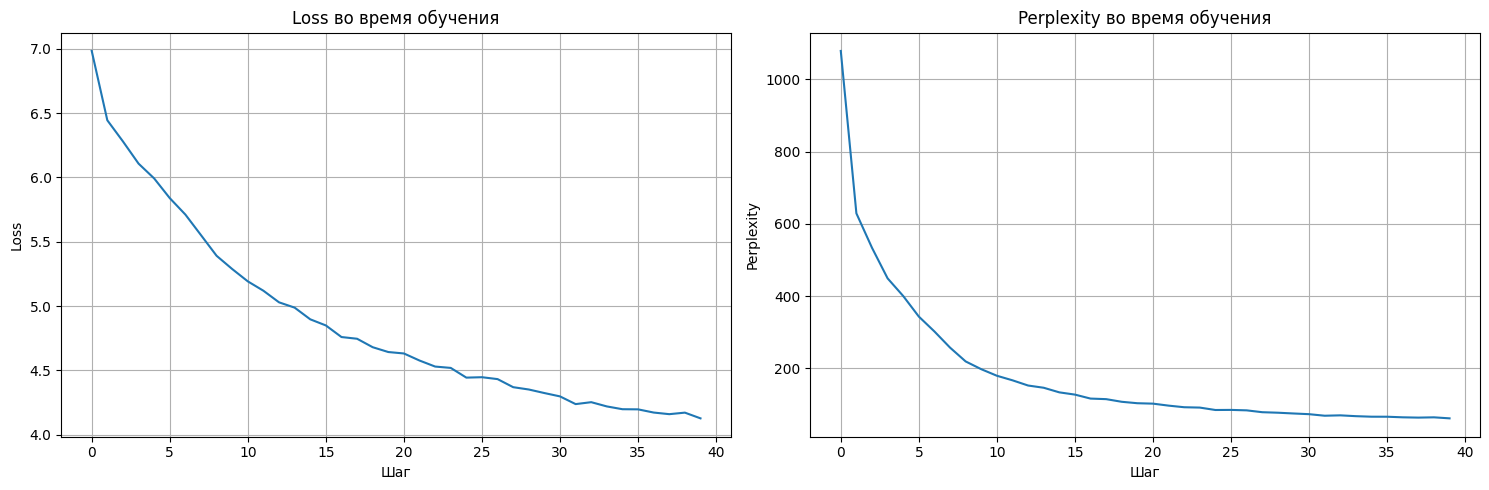

--> Финальный loss: 4.1277
--> Финальная perplexity: 62.0351


In [63]:
#  9 : 
# Графики прогресса обучения

def plot_training_progress(callback):
    """Визуализация прогресса обучения"""
    if not callback.losses:
        print("❌ Нет данных для визуализации")
        return
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(callback.losses)
    plt.title('Loss во время обучения')
    plt.xlabel('Шаг')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(callback.perplexities)
    plt.title('Perplexity во время обучения')
    plt.xlabel('Шаг')
    plt.ylabel('Perplexity')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Статистика
    print(f"--> Финальный loss: {callback.losses[-1]:.4f}")
    print(f"--> Финальная perplexity: {callback.perplexities[-1]:.4f}")

# Визуализация прогресса
plot_training_progress(validation_callback)

In [52]:
#  10 : 
# Сохранение модели и финальная оценка

print("🔄 Сохранение модели...")
trainer.save_model(Config.MODEL_SAVE_PATH)
tokenizer.save_pretrained(Config.MODEL_SAVE_PATH)
print(f"✅ Модель сохранена в {Config.MODEL_SAVE_PATH}")

# Финальная оценка
class QualityEvaluator:
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
    
    def evaluate_generation(self, max_length=100):
        """Оценка качества генерации"""
        print("\n Финальная оценка качества:")
        print("=" * 55)
        
        self.model.eval()
        results = []
        
        with torch.no_grad():
            for i, prompt in enumerate(Config.TEST_PROMPTS):
                prompt=prompt.lower()
                inputs = self.tokenizer.encode(prompt, return_tensors="pt")
                
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                
                outputs = self.model.generate(
                    inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.85,
                    pad_token_id=self.tokenizer.pad_token_id,
                )
                
                generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
                
                print(f"\n Промпт {i+1}: {prompt}")
                print(f"-> Сгенерированный моделью текст: {generated_text}")
                print("-" * 55)
                
                results.append({
                    'prompt': prompt,
                    'generated_text_raw': generated_text
                })
        
        return results

# Загрузка обученной модели для оценки
print("\n🔄 Загрузка обученной модели для оценки...")
trained_model = LlamaForCausalLM.from_pretrained(Config.MODEL_SAVE_PATH)
trained_tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_SAVE_PATH)

evaluator = QualityEvaluator(trained_tokenizer, trained_model)
final_results = evaluator.evaluate_generation()

# Сохранение результатов
with open(f"{Config.MODEL_SAVE_PATH}/final_results.json", "w", encoding="utf-8") as f:
    json.dump(final_results, f, ensure_ascii=False, indent=2)

print(f"\n✅ Результаты сохранены в {Config.MODEL_SAVE_PATH}/final_results.json")

🔄 Сохранение модели...
✅ Модель сохранена в ./llm_model

🔄 Загрузка обученной модели для оценки...

 Финальная оценка качества:

 Промпт 1: все мысли, которые имеют огромные последствия
-> Сгенерированный моделью текст: все мысли , которые име ют огром ные послед ствия . он был в первый раз , не мог и с ним по знако ми ться . князь андрей по нимал , что ему надо было видеть . он был очень хоро ш , как будто он был , и что он сам в том , что он никогда не может быть . князь , князь , князь и ппо лит , князь , что он сам не хочет , что он по знако ми лся и что , князь , он с читал , что он так и не так , как он , как будто его знает ,
-------------------------------------------------------

 Промпт 2: сила войска зависит от его духа
-> Сгенерированный моделью текст: сила вой ска зави си т от его ду ха . с того , как вы , как это вы не знаете . - с доса дой про мол вил степан арка дь ич . - а вы , господа , и вы . - проговорил он , не до жи да ясь . - да , - сказал он , с ходя по комнате 